In [ ]:
# 1. Creating a Databricks Notebook
# Simple Python code to read data and perform calculations
data = [10,20,30,40,50]
total_sum = sum(data)
print(f"Sum of data: {total_sum}")


Sum of data: 15


In [ ]:
# 2. Setting Up Azure Databricks Workspace and Configuring Clusters
print("Clusters are configured and attached to notebook")

Clusters are configured and attached to notebook


In [ ]:
dbutils.fs.cp("file:/Workspace/Shared/real_time_streaming_data.csv","dbfs:/FileStore/real_time_streaming_data.csv")

True

In [ ]:
dbutils.fs.cp("file:/Workspace/Shared/exe_sales_data.csv","dbfs:/FileStore/exe_sales_data.csv")

True

In [ ]:
dbutils.fs.cp("file:/Workspace/Shared/exe_transaction_data.csv","dbfs:/FileStore/exe_transaction_data.csv")

True

In [ ]:
# 3. Real-time data processing with databricks
# Use spark.readStream to simulate real-time data processing.
schema="event_time TIMESTAMP, event_type STRING, user_id STRING, amount DOUBLE"
streamind_data=spark.readStream.format("csv").schema(schema).option("header","true").load("dbfs:/FileStore/")
# Real-time aggregation
aggregated_data=(streamind_data.groupBy("event_type").agg({"amount":"sum"}).withColumnRenamed("sum(amount)","total_amount"))
query = (aggregated_data.writeStream
         .outputMode("complete")
         .format("console")
         .start())

In [ ]:
# 4. Data Exploration and Visualization in Databricks
# Load a dataset and perform exploratory data analysis (EDA)
from pyspark.sql.functions import col
df = spark.read.csv("dbfs:/FileStore/exe_sales_data.csv", header=True, inferSchema=True)
df = df.withColumn("amount", df["amount"].cast("double")) \
.withColumn("quantity", df["quantity"].cast("int"))

# Show the first few records
df.show(5)


+--------------+---------+------+--------+-----------+
|transaction_id| category|amount|quantity|customer_id|
+--------------+---------+------+--------+-----------+
|             1| clothing|274.08|      19|       5622|
|             2|    books|282.48|       6|       9363|
|             3| clothing| 756.3|       8|       1750|
|             4| clothing|331.44|       4|       5916|
|             5|furniture|533.77|       2|       5679|
+--------------+---------+------+--------+-----------+
only showing top 5 rows



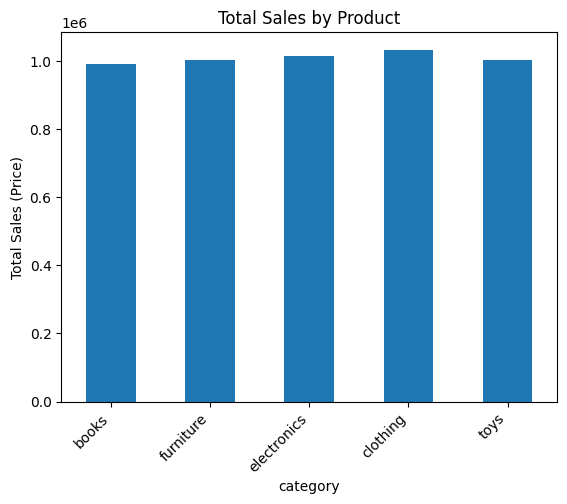

In [ ]:
import matplotlib.pyplot as plt
# Convert the total sales per product to Pandas
df_pandas_category = df.groupBy("category").agg({"amount": "sum"}).toPandas()
# Plot using Matplotlib
df_pandas_category.plot(kind='bar', x='category', y='sum(amount)', legend=False)
# Customize the plot
plt.title("Total Sales by Product")
plt.xlabel("category")
plt.ylabel("Total Sales (Price)")
plt.xticks(rotation=45, ha='right')
plt.show()


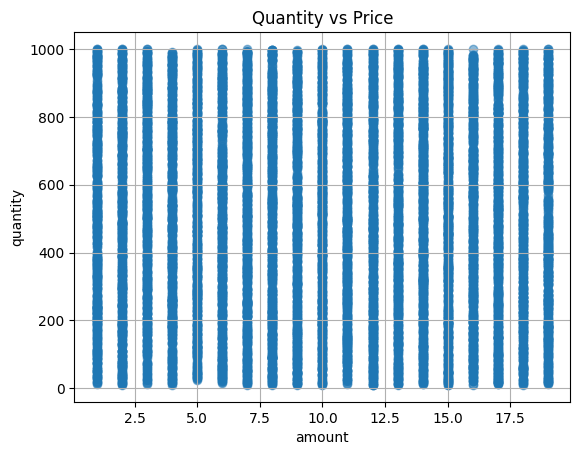

In [ ]:
# Convert the necessary columns to Pandas
df_pandas_scatter = df.select("quantity", "amount").toPandas()
# Plot using Matplotlib
plt.scatter(df_pandas_scatter['quantity'], df_pandas_scatter['amount'], alpha=0.5)
# Customize the plot
plt.title("Quantity vs Price")
plt.xlabel("amount")
plt.ylabel("quantity")
plt.grid(True)
plt.show()

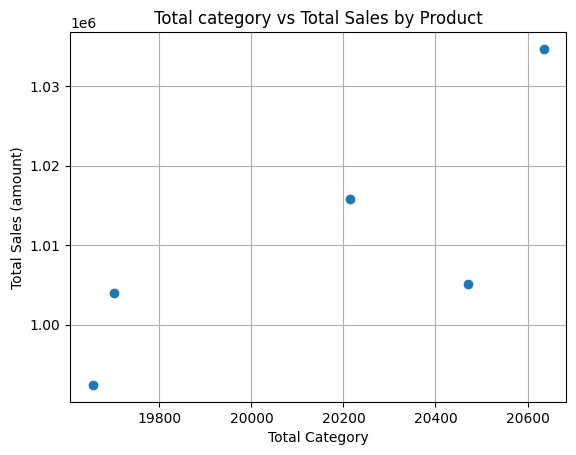

In [ ]:
# Group by product, sum the quantity and price, and convert to Pandas
df_pandas_quantity_vs_sales = df.groupBy("category") \
    .agg({"quantity": "sum", "amount": "sum"}).toPandas()

# Plot using Matplotlib
plt.scatter(df_pandas_quantity_vs_sales['sum(quantity)'], df_pandas_quantity_vs_sales['sum(amount)'])

# Customize the plot
plt.title("Total category vs Total Sales by Product")
plt.xlabel("Total Category")
plt.ylabel("Total Sales (amount)")
plt.grid(True)
plt.show()

In [ ]:
# 5. Reading and Writing Data in Databricks
# Read data in different formats and write it to Delta, Parquet, and JSON
# Reading CSV file
df_csv = spark.read.csv("dbfs:/FileStore/exe_sales_data.csv", header=True, inferSchema=True)
# Writing to Delta format
df_csv.write.format("delta").mode("overwrite").save("dbfs:/FileStore/delta_table")
print("Writing to the delta table completed")
# Writing to Parquet
df_csv.write.mode("overwrite").parquet("dbfs:/FileStore/parquet_table")
print("Writing to the parquet file completed")
# Writing to JSON
df_csv.write.mode("overwrite").json("dbfs:/FileStore/json_table")
print("Writing to the json file completed")

Writing to the delta table completed
Writing to the parquet file completed
Writing to the json file completed


In [ ]:
# 6. Analyzing and Visualizing Streaming Data with Databricks
# Use Spark streaming to analyze and visualize streaming data in real time
streaming_data = (spark.readStream.format("csv").option("header", "true").schema(schema).load("dbfs:/FileStore/"))

streaming_data_with_watermark = streaming_data.withWatermark("event_time", "10 minutes")

# Real-time visualization of total amount over time
streaming_data_with_watermark.groupBy("event_time").sum("amount").writeStream.outputMode("append").format("console").start()

In [ ]:
# 7. Introduction to Databricks Delta Lake
# Creating a Delta Table
df.write.mode("overwrite").format("delta").save("/delta/transactions")
# Updating the Delta Table
spark.sql("UPDATE delta.`/delta/transactions` SET amount = amount * 1.1 WHERE customer_id = 9363")
# Time travel
previous_version = spark.read.format("delta").option("versionAsOf", 1).load("/delta/transactions")
previous_version.show()


+--------------+-----------+------+--------+-----------+
|transaction_id|   category|amount|quantity|customer_id|
+--------------+-----------+------+--------+-----------+
|             1|   clothing|274.08|      19|       5622|
|             2|      books|282.48|       6|       9363|
|             3|   clothing| 756.3|       8|       1750|
|             4|   clothing|331.44|       4|       5916|
|             5|  furniture|533.77|       2|       5679|
|             6|  furniture|462.65|      17|       9939|
|             7|  furniture|223.61|      13|       5965|
|             8|      books|361.29|       8|       8995|
|             9|   clothing|692.52|      12|       5244|
|            10|  furniture|813.56|      14|       9397|
|            11|electronics|827.77|      15|       8967|
|            12|       toys|409.23|       9|       6482|
|            13|  furniture|462.51|      10|       5949|
|            14|   clothing|881.36|       3|       3818|
|            15|  furniture|790

In [ ]:
# 8. Managed and Unmanaged Tables
df.write.saveAsTable("managed_table_1")

# Creating an unmanaged table (external location)
df.write.option("dbfs:/FileStore/sales_data_2", "/mnt/sales_data").saveAsTable("unmanaged_sales")

# Selecting data
spark.sql("SELECT * FROM managed_table_1").show()

+--------------+-----------+------+--------+-----------+
|transaction_id|   category|amount|quantity|customer_id|
+--------------+-----------+------+--------+-----------+
|             1|   clothing|274.08|      19|       5622|
|             2|      books|282.48|       6|       9363|
|             3|   clothing| 756.3|       8|       1750|
|             4|   clothing|331.44|       4|       5916|
|             5|  furniture|533.77|       2|       5679|
|             6|  furniture|462.65|      17|       9939|
|             7|  furniture|223.61|      13|       5965|
|             8|      books|361.29|       8|       8995|
|             9|   clothing|692.52|      12|       5244|
|            10|  furniture|813.56|      14|       9397|
|            11|electronics|827.77|      15|       8967|
|            12|       toys|409.23|       9|       6482|
|            13|  furniture|462.51|      10|       5949|
|            14|   clothing|881.36|       3|       3818|
|            15|  furniture|790

In [ ]:
# Creating a view
df.createOrReplaceTempView("temp_view")

# Creating a global temporary view
df.createOrReplaceGlobalTempView("global_temp_view")

# Querying the views
spark.sql("SELECT * FROM temp_view").show()
spark.sql("SELECT * FROM global_temp.global_temp_view").show()


+--------------+-----------+------+--------+-----------+
|transaction_id|   category|amount|quantity|customer_id|
+--------------+-----------+------+--------+-----------+
|             1|   clothing|274.08|      19|       5622|
|             2|      books|282.48|       6|       9363|
|             3|   clothing| 756.3|       8|       1750|
|             4|   clothing|331.44|       4|       5916|
|             5|  furniture|533.77|       2|       5679|
|             6|  furniture|462.65|      17|       9939|
|             7|  furniture|223.61|      13|       5965|
|             8|      books|361.29|       8|       8995|
|             9|   clothing|692.52|      12|       5244|
|            10|  furniture|813.56|      14|       9397|
|            11|electronics|827.77|      15|       8967|
|            12|       toys|409.23|       9|       6482|
|            13|  furniture|462.51|      10|       5949|
|            14|   clothing|881.36|       3|       3818|
|            15|  furniture|790